In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import pickle 
import random
from tqdm import tqdm

In [2]:
import networkx as nx

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [4]:
from matplotlib.colors import LinearSegmentedColormap


In [5]:

dff = pd.read_csv("./data/df_XY.csv")

dff.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
dff['Date'] = dff.Date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d') )
dff = dff.set_index(['Date'])


# hyper-parameters

In [6]:

dff_date = dff.index
dff_col_name = list(dff.columns)

tr_days = 253 # trading days = 253 (1 year trading days)
feat_date = dff_date[tr_days:]

# Feature Generation  
Individual Asset   
concated version (dff)

- rolling volatility
- rolling return 
- rolling correlation 
- min-max price value (individual movement)
- XY correlation 

- 200 mv : meb faber (ref)
- adj_mx
- Centrality
https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.418.7183&rep=rep1&type=pdf



In [7]:
def return_volatility(df_bench):
    '''
    return & volatility
    '''  
    logret = np.log(df_bench/df_bench.shift(1)).dropna()
    T = logret.shape[0]

    sigma = logret.cov() * T # annualize sigma (check again)
    mu = logret.mean()*T

    return mu, sigma


## rolling log-return(Momentum) & rolling volatility

In [8]:

for count, end_pt in tqdm(enumerate(range(tr_days, len(dff_date)))):
    dff_yr = dff.iloc[end_pt-tr_days : end_pt-20] # pr1yr data
    
    mu, sigma = return_volatility(dff_yr)  # log-ret, sigma
    
    if count == 0:
        prev_mu_arr = np.expand_dims(mu.values, 0)
        prev_sigma_arr = np.expand_dims(np.array([sigma.iloc[i][i] for i in range(sigma.shape[0])]),0)
        
    else:
        mu_arr = np.expand_dims(mu.values, 0)
        sigma_arr = np.expand_dims(np.array([sigma.iloc[i][i] for i in range(sigma.shape[0])]),0)
    
        prev_mu_arr = np.concatenate([prev_mu_arr, mu_arr], axis = 0)
        prev_sigma_arr = np.concatenate([prev_sigma_arr, sigma_arr], axis = 0)                              
    
    
    
    


7931it [00:32, 245.05it/s]


In [9]:
mu_df = pd.DataFrame(prev_mu_arr, columns = dff_col_name, index = feat_date)
sigma_df = pd.DataFrame(prev_sigma_arr, columns = dff_col_name, index = feat_date)

In [10]:
mu_arr, sigma_arr = np.expand_dims(mu_df.values, axis = -1), np.expand_dims(sigma_df.values, axis = -1)

In [11]:
# features concatenation 

feat_arr = np.concatenate([mu_arr, sigma_arr], axis = -1) # feat 1: mu, feat 2: sig

# adj mx

In [12]:
z_scaler = StandardScaler()
z_scaler.fit(dff)
df_z = z_scaler.transform(dff)
df_z = pd.DataFrame(df_z, columns = dff_col_name, index = dff_date)

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(dff)
df_mm = min_max_scaler.transform(dff)
df_mm = pd.DataFrame(df_mm, columns = dff_col_name, index = dff_date)




In [13]:
def adj_generate(df_corr, min_threshold = 0.9, max_threshold = 1):
    '''
    input : df_corr(dataframe representing correlation)
    output : dataframe with 0, 1 (connectivity)
    '''
    df_adj = df_corr.applymap(lambda x : 1 if (abs(x)>min_threshold) & (abs(x)<max_threshold) else 0)
    return df_adj

Text(0.5, 1.0, 'Correlation of Price 1990.12.20~2021.05.13')

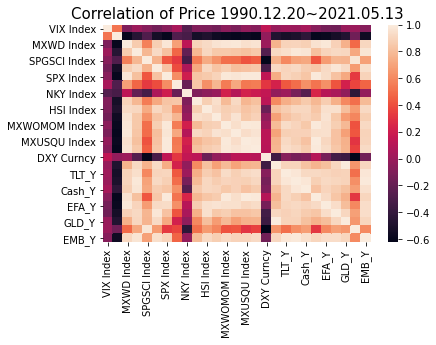

In [14]:
sns.heatmap(dff.corr())
plt.title("Correlation of Price 1990.12.20~2021.05.13", fontsize = 15)

Text(0.5, 1.0, 'Correlation of Return 1990.12.20~2021.05.13')

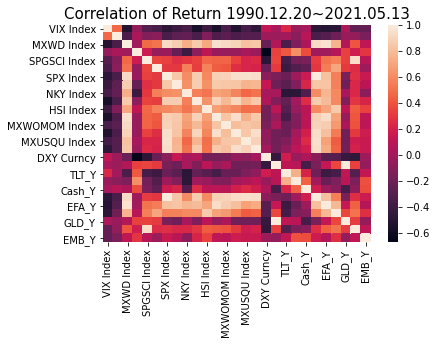

In [15]:
sns.heatmap(mu_df.corr())
plt.title("Correlation of Return 1990.12.20~2021.05.13", fontsize = 15)

Text(0.5, 1.0, 'Correlation of Return 1990.12.20~2021.05.13')

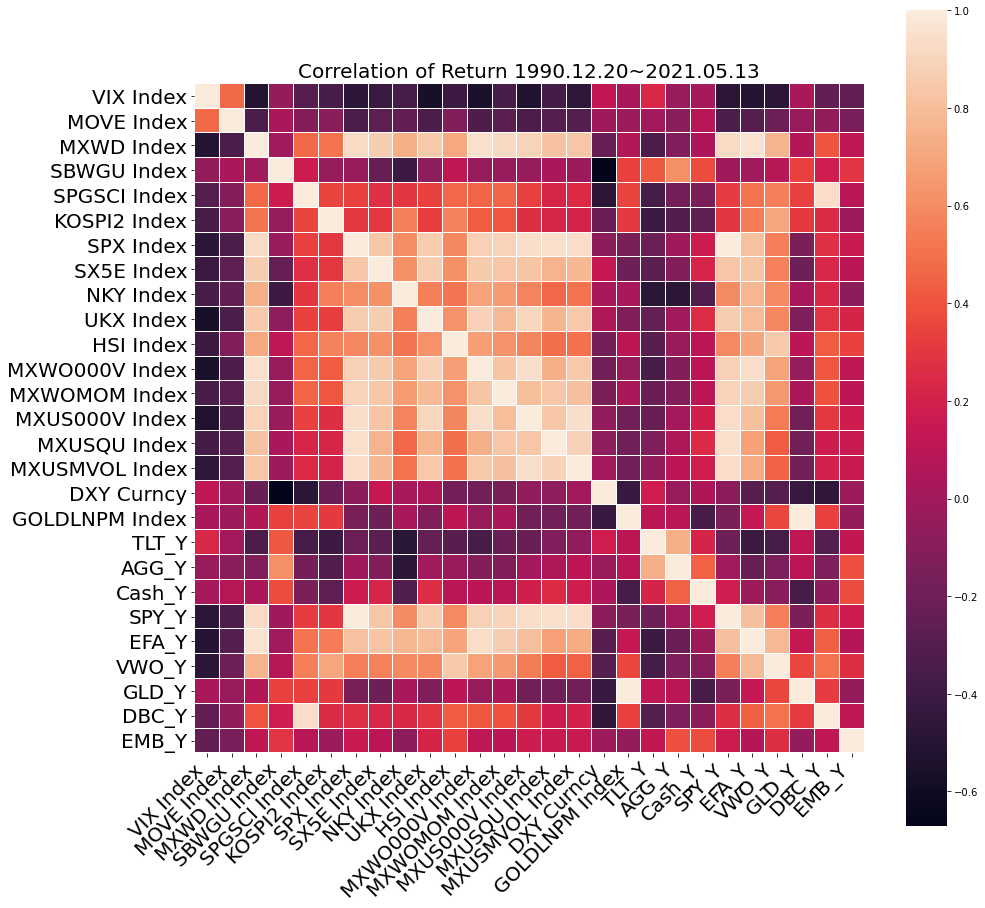

In [16]:
plt.figure(figsize = (15,15))
h = sns.heatmap(mu_df.corr(), linewidth = 0.01, square = True)
h.set_xticklabels(h.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xticks(fontsize = (20))
plt.yticks(fontsize = (20))
plt.title("Correlation of Return 1990.12.20~2021.05.13", fontsize = 20)

Text(0.5, 1.0, 'adjacency matrix with price')

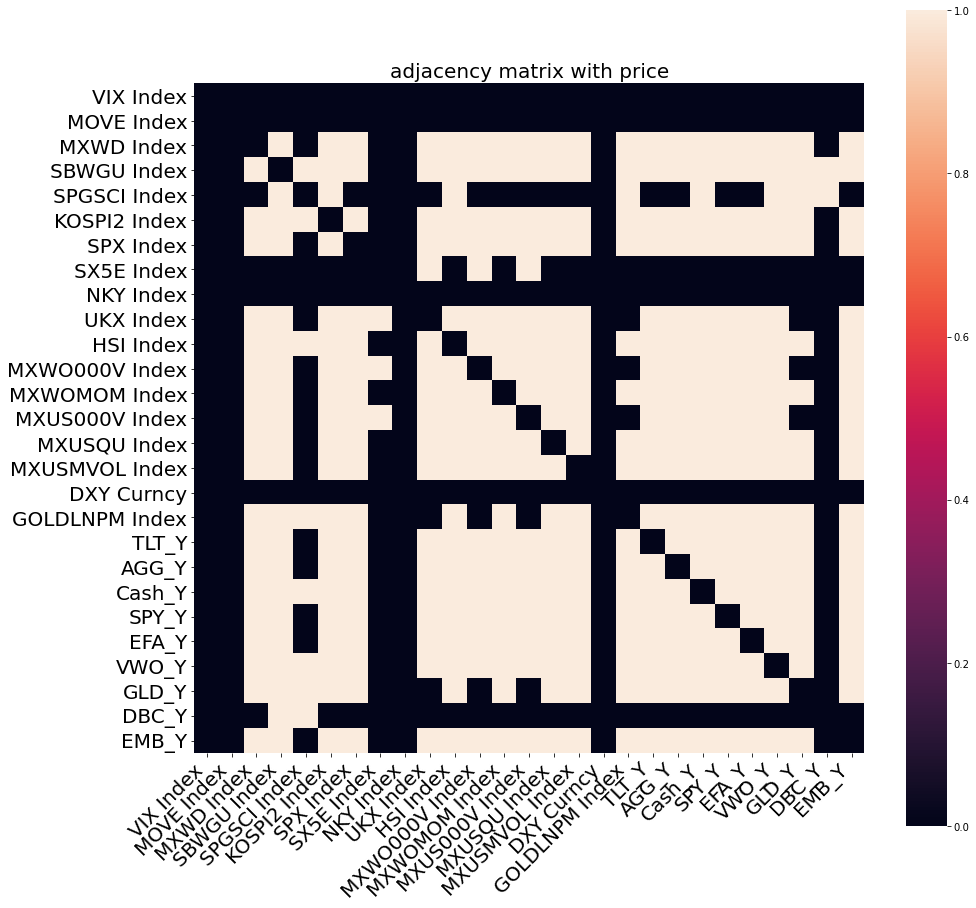

In [37]:
# z-score, min-max norm , normal price -> correlation identical
plt.figure(figsize = (15,15))
h = sns.heatmap(adj_generate(dff.corr(), 0.7), square = True)
h.set_xticklabels(h.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xticks(fontsize = (20))
plt.yticks(fontsize = (20))
plt.title("adjacency matrix with price", fontsize = 20)

Text(0.5, 1.0, 'adjacency matrix with return')

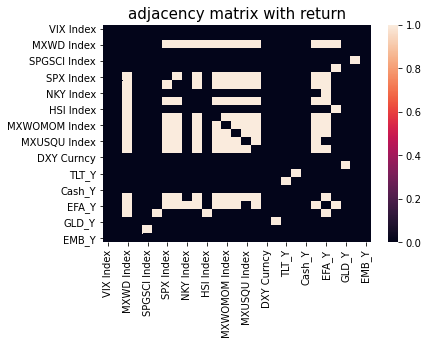

In [18]:
sns.heatmap(adj_generate(mu_df.corr(), 0.7))
plt.title("adjacency matrix with return", fontsize = 15)

In [19]:
G = nx.Graph()

In [20]:
# adj mx based on return 
adj_df = adj_generate(mu_df.corr(), 0.7)

In [21]:
import scipy.sparse as sp

cols = adj_df.columns
X = sp.csr_matrix(adj_df.astype(int).values)
Xc = X.T * X  # multiply sparse matrix
Xc.setdiag(0)  # reset diagonal

# create dataframe from co-occurence matrix in dense format
# df = pd.DataFrame(Xc.todense(), index=cols, columns=cols)

/home/juyeong/anaconda3/envs/QRFT/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [22]:
cols = adj_df.columns 
X = sp.csr_matrix(adj_df.astype(int).values)

In [23]:
adj_deg_df = pd.DataFrame(Xc.todense(), index=cols, columns=cols) # degree matrix 

In [24]:
adj_deg_df

,VIX Index,MOVE Index,MXWD Index,SBWGU Index,SPGSCI Index,KOSPI2 Index,SPX Index,SX5E Index,NKY Index,UKX Index,...,GOLDLNPM Index,TLT_Y,AGG_Y,Cash_Y,SPY_Y,EFA_Y,VWO_Y,GLD_Y,DBC_Y,EMB_Y
VIX Index,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MOVE Index,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MXWD Index,0,0,0,0,0,1,9,9,1,9,...,0,0,0,0,9,10,2,0,0,0
SBWGU Index,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SPGSCI Index,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KOSPI2 Index,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
SPX Index,0,0,9,0,0,0,0,9,2,9,...,0,0,0,0,9,8,2,0,0,0
SX5E Index,0,0,9,0,0,0,9,0,2,9,...,0,0,0,0,9,8,2,0,0,0
NKY Index,0,0,1,0,0,0,2,2,0,2,...,0,0,0,0,2,1,2,0,0,0
UKX Index,0,0,9,0,0,0,9,9,2,0,...,0,0,0,0,9,8,2,0,0,0


In [25]:
adj_deg_df.stack().reset_index()

,level_0,level_1,0
0,VIX Index,VIX Index,0
1,VIX Index,MOVE Index,0
2,VIX Index,MXWD Index,0
3,VIX Index,SBWGU Index,0
4,VIX Index,SPGSCI Index,0
...,...,...,...
724,EMB_Y,EFA_Y,0
725,EMB_Y,VWO_Y,0
726,EMB_Y,GLD_Y,0
727,EMB_Y,DBC_Y,0


In [26]:
adj_deg_df = adj_deg_df.stack().reset_index()
adj_deg_df.columns = ['source', 'target', 'weight']

# adj_weight = adj_deg_df[adj_deg_df['weight'] != 0] 

g = nx.from_pandas_edgelist(adj_deg_df, 'source', 'target', ['weight'])

In [27]:
adj_df.index

Index(['VIX Index', 'MOVE Index', 'MXWD Index', 'SBWGU Index', 'SPGSCI Index',
       'KOSPI2 Index', 'SPX Index', 'SX5E Index', 'NKY Index', 'UKX Index',
       'HSI Index', 'MXWO000V Index', 'MXWOMOM Index', 'MXUS000V Index',
       'MXUSQU Index', 'MXUSMVOL Index', 'DXY Curncy', 'GOLDLNPM Index',
       'TLT_Y', 'AGG_Y', 'Cash_Y', 'SPY_Y', 'EFA_Y', 'VWO_Y', 'GLD_Y', 'DBC_Y',
       'EMB_Y'],
      dtype='object')

In [28]:
adj_df.columns

Index(['VIX Index', 'MOVE Index', 'MXWD Index', 'SBWGU Index', 'SPGSCI Index',
       'KOSPI2 Index', 'SPX Index', 'SX5E Index', 'NKY Index', 'UKX Index',
       'HSI Index', 'MXWO000V Index', 'MXWOMOM Index', 'MXUS000V Index',
       'MXUSQU Index', 'MXUSMVOL Index', 'DXY Curncy', 'GOLDLNPM Index',
       'TLT_Y', 'AGG_Y', 'Cash_Y', 'SPY_Y', 'EFA_Y', 'VWO_Y', 'GLD_Y', 'DBC_Y',
       'EMB_Y'],
      dtype='object')

In [29]:
edge_list = []
for i in range(len(adj_df.columns)):
    for j in range(len(adj_df.columns)):
        
        if adj_df.values[i][j] == 1:
            edge_list.append((adj_df.columns[i], adj_df.columns[j]))

In [30]:
# network generation 

G = nx.Graph()
G.add_edges_from(edge_list)

In [31]:
(G.nodes)

NodeView(('MXWD Index', 'SPX Index', 'SX5E Index', 'NKY Index', 'UKX Index', 'HSI Index', 'MXWO000V Index', 'MXWOMOM Index', 'MXUS000V Index', 'MXUSQU Index', 'MXUSMVOL Index', 'SPY_Y', 'EFA_Y', 'VWO_Y', 'SPGSCI Index', 'DBC_Y', 'KOSPI2 Index', 'GOLDLNPM Index', 'GLD_Y', 'TLT_Y', 'AGG_Y'))

In [32]:
G.edges

EdgeView([('MXWD Index', 'SPX Index'), ('MXWD Index', 'SX5E Index'), ('MXWD Index', 'NKY Index'), ('MXWD Index', 'UKX Index'), ('MXWD Index', 'HSI Index'), ('MXWD Index', 'MXWO000V Index'), ('MXWD Index', 'MXWOMOM Index'), ('MXWD Index', 'MXUS000V Index'), ('MXWD Index', 'MXUSQU Index'), ('MXWD Index', 'MXUSMVOL Index'), ('MXWD Index', 'SPY_Y'), ('MXWD Index', 'EFA_Y'), ('MXWD Index', 'VWO_Y'), ('SPX Index', 'SX5E Index'), ('SPX Index', 'UKX Index'), ('SPX Index', 'MXWO000V Index'), ('SPX Index', 'MXWOMOM Index'), ('SPX Index', 'MXUS000V Index'), ('SPX Index', 'MXUSQU Index'), ('SPX Index', 'MXUSMVOL Index'), ('SPX Index', 'SPY_Y'), ('SPX Index', 'EFA_Y'), ('SX5E Index', 'UKX Index'), ('SX5E Index', 'MXWO000V Index'), ('SX5E Index', 'MXWOMOM Index'), ('SX5E Index', 'MXUS000V Index'), ('SX5E Index', 'MXUSQU Index'), ('SX5E Index', 'MXUSMVOL Index'), ('SX5E Index', 'SPY_Y'), ('SX5E Index', 'EFA_Y'), ('NKY Index', 'EFA_Y'), ('UKX Index', 'MXWO000V Index'), ('UKX Index', 'MXWOMOM Index'), 

NetworkXError: random_state_index is incorrect

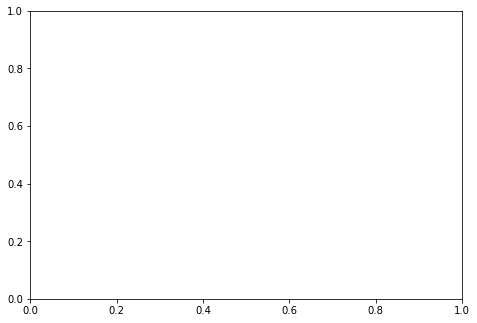

In [33]:
# 그림이 안그려진다. 
# for node in G.nodes:
#     G.nodes[node]['pos'] = 
nx.draw(G)

## Direct adjacency matrix generation impossible
- there are non-connected node existed

In [ ]:
G.edges

In [ ]:
dff.shape

In [ ]:
price_df = dff.loc[feat_date]

price_arr = price_df.values

price_arr = np.expand_dims(price_arr, axis = -1)

In [ ]:
np.concatenate([price_arr, feat_arr], axis = -1).shape

In [ ]:
feat_arr.shape

In [ ]:
feat_arr = np.concatenate([price_arr, feat_arr], axis = -1)

# to_csv

In [ ]:
price_df.to_csv("./data/features/price_df.csv", index = True)

In [ ]:
mu_df.to_csv("./data/features/mu_df.csv", index = True)
sigma_df.to_csv("./data/features/sigma_df.csv", index = True)